In [1]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("ERROR: GPU DEVICE NOT FOUND.")

from tensorflow.keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import math
import Simulator_Functions as SF

from Simulator_Functions import Select_Vissim_Mode
from RLAgents import DQNAgent
from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload
from TupleToList import toList
from Utilities import log_progress, pltlive
## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
import PER

%matplotlib inline

Default GPU Device: /device:GPU:0


In [2]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes and copy weights with frequency "f"
episodes = 50
partial_save_at =  5 # 100 
copy_weights_frequency = 2 #10

# Hyperparameters
Surtrac = False
PER_activated = True
batch_size = 64
memory_size = 1024
alpha   = 0.000065
gamma   = 0.95

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
timesteps_per_second = 1
seconds_per_green = 6
seconds_per_yellow = 3
simulation_length = 3600*1 + 1
memory_population_length = batch_size*seconds_per_green*2.5 +1
if PER_activated:
    memory_population_length = int(memory_size*seconds_per_green*1.6) +1

# Vissim autosave the result of the simulation    
delete_results = True

## State-Action Parameters
action_type = "phases"        # options are "phases" and "programs"
state_size = 4
action_size = 8

# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "geometric"
epsilon_start = 1
epsilon_end   = 0.001
if exploration_schedule == "linear":
    epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
    epsilon_sequence = [1 + epsilon_decay * entry for entry in range(episodes+1)]
    epsilon_sequence = [0 if entry < 0 else entry for entry in epsilon_sequence]
elif exploration_schedule == "geometric":
    epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
    epsilon_sequence = [epsilon_start * epsilon_decay ** entry for entry in range(episodes+1)]
else:
    print("ERROR: Unrecognized choice of exploration schedule.")

# Demand Schedule (times in seconds, demand in cars/hour as PPP)
demand_change_timesteps = 450
demand = {"h":600, 'm':300, 'l':150}
demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
              [demand['h'], demand['l']], [demand['h'], demand['m']],\
              [demand['h'], demand['h']], [demand['m'], demand['h']],
              [demand['l'], demand['h']], [demand['l'], demand['m']]]

In [3]:
## Operation mode (selects functionalities)
mode = "training"
# "populate" = population of memory, generation of initial memory file
# "training" = training agents, maximum speed, frozen UI, mid amount of messages
# "debug"    = trains for 1 episode, minimum speed, working UI, all messages
# "demo"     = loads pretrained agent, minimum speed, working UI
# "test"     = executes evaluation, maximum speed

if mode == 'demo' :
    simulation_length = 3600
    demand_list = [[demand['l'], demand['l']]]
    demand_change_timesteps = simulation_length
    
    
if mode == 'test' : 
    simulation_length = 3600
    demand_change_timesteps = 450
    demand = {"h":800, 'm':400, 'l':200}
    demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
                  [demand['h'], demand['l']], [demand['h'], demand['m']],\
                  [demand['h'], demand['h']], [demand['m'], demand['h']],
                  [demand['l'], demand['h']], [demand['l'], demand['m']]]
    delete_results = False

model_name  = 'Single_Cross_Triple'
# 'Single_Cross_Straight'
# 'Single_Cross_Triple'
# 'Balance'

vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
# vissim_working_directory = 'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisationOrigine\\Vissim\\'
agent_type = 'DuelingDDQN'        # DQN, DuelingDQN, DDQN, DuelingDDQN
reward_type = 'Queues'   
# 'Queues'          Sum of the queues for all lanes in intersection
# 'QueuesDiff'      Difference in queue lengths in last timestep
# 'QueuesDiffSC'    10000* QueuesDiff - Queues^2
# 'TotalDelayDiff'

state_type  = 'Queues'    # 'Queues', 'Delays', 'QueuesDifference' 'QueuesSpeedavrOccuperateSig' 'QueuesSig'
Random_Seed = 42

## Use of additional files?
flag_read_additionally  = False
SaveResultsAgent = True
# Random demand
Random_Demand = False

# Session ID
#Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_Act_"+action_type+"_Rew_"+reward_type

# Adding the state type to the Session_ID
Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_State_"+state_type+"_Act_"+action_type+"_Rew_"+reward_type
print(Session_ID)

Ep_50_A_DuelingDDQN_State_Queues_Act_phases_Rew_Queues


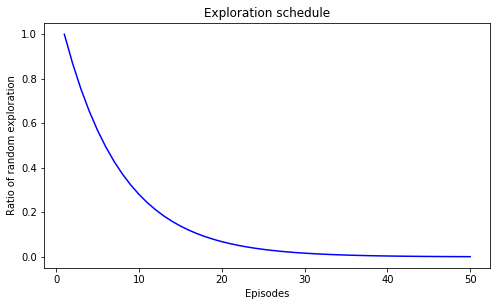

In [ ]:
# Plotting exploration schedule
plt.figure(figsize=(8,4.5))
x_series = np.array(range(1,episodes+1))
y_series = epsilon_sequence[0:episodes]
plt.plot(x_series, y_series, '-b')
plt.xlabel('Episodes')
plt.ylabel('Ratio of random exploration')
plt.title('Exploration schedule')
plt.show()

In [ ]:
if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    best_agent_memory = []
    reward_plot = np.zeros([episodes,])
    loss_plot = np.zeros([episodes,])

    # Initialize simulation
    Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                memory_population_length if mode == 'training' else simulation_length , timesteps_per_second,\
                                                                delete_results = delete_results, verbose = True)
        
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                           gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                           DoubleDQN = True if agent_type == "DDQN" or agent_type =="DuelingDDQN" else False,\
                           Dueling = False if agent_type == "DQN" or agent_type == "DDQN" else True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))
    
    ## EXECUTION OF A DEMONSTRATION, POPULATION, DEBUG OR TEST ITERATION
    if mode == "demo" or mode == "populate" or mode == "debug" or mode == "test":
        # If mode or debug, set slow simulation
        if mode == "demo" or mode =="debug":
            timesteps_per_second = 10
            Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
            
        # If memory population or test mode, set quick simulation
        elif mode == "populate" or mode == "test":
            SF.Set_Quickmode(Vissim, timesteps_per_second)
            
        # If on a test or a demo, load the best available agent and set exploration to zero
        if mode == "demo" or mode == "test":
            Agents, reward_storage = SF.load_agents(vissim_working_directory, model_name, Agents,\
                                    Session_ID, best = True)
            for agent in Agents:
                agent.epsilon = 0 #1
        
        # Run the episode
        if mode == "demo" or mode == "debug":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "test":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "populate":
            if PER_activated:
                memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                                vissim_working_directory, model_name, Session_ID,\
                                                                seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                                demand_list, demand_change_timesteps, PER_activated)
                print("PER memory prepopulated with {} entries".format(memory_size))
        
        Vissim = None
     
    ## EXECUTION OF THE NORMAL TRAINING LOOP
    elif mode == "training":
        # Load previous memory if available, else create it
        SF.Set_Quickmode(Vissim, timesteps_per_second)
        memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                        vissim_working_directory, model_name, Session_ID,\
                                                        seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                        demand_list, demand_change_timesteps, PER_activated)
        print('Memory pre-populated. Starting Training.\n')
        
        # Iterations of the simulation
        for episode in log_progress(range(episodes), every=1):
        
            # Reload map if it has already been run (previous episode or prepopulation)
            if episode !=0 or runflag == True:
                Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                      simulation_length, timesteps_per_second, delete_results = True)

                # Run Network Parser and ensure agents are linked to their intersections
                npa = NetworkParser(Vissim)
                for index, agent in enumerate(Agents):
                    agent.update_IDS(agent.signal_id, npa)
                    agent.episode_reward = []

            # Change the random seed
            Random_Seed += 1
            Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
                    
            # Run Episode at maximum speed
            SF.Select_Vissim_Mode(Vissim, mode)
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length, timesteps_per_second,\
                                      seconds_per_green, seconds_per_yellow, demand_list, demand_change_timesteps, mode,\
                                      PER_activated)
        
            # Calculate episode average reward
            reward_storage, average_reward = SF.average_reward(reward_storage, Agents, episode, episodes)
            best_agent_weights, best_agent_memory = SF.best_agent(reward_storage, average_reward,\
                                                                  best_agent_weights, best_agent_memory,\
                                                                  vissim_working_directory, model_name, Agents, Session_ID)
        
           
             # Train agent with experience of episode and copy weights when necessary
            # Update exploration rate
            for agent in Agents: 
                for _ in range(5):
                    agent.learn_batch(batch_size, episode)
            # Copy weights 
                if (episode+1) % agent.copy_weights_frequency == 0 and episode != 0:
                    agent.copy_weights()
                agent.epsilon = epsilon_sequence[episode+1]
            
            # Security save for long trainings
            if SaveResultsAgent:
                if (episode+1)%partial_save_at == 0:
                    SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
                    print('Saved Partial results at the end of episode {}.'.format(episode+1))

        #Saving agents memory, weights and optimizer
        if SaveResultsAgent:
            SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
            print("Model, architecture, weights, optimizer, memory and training results succesfully saved.\
            Succesfully Terminated.")
    
    else:
        raise Exception("ERROR: Mode selected not recognized. TERMINATING.")
    # Close Vissim
    Vissim = None

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Triple.inpx ...
Load process successful
Simulation length set to 9831 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
NetworkParser has succesfully crawled the model network.
Instructions for updating:
Colocations handled automatically by placer.
Instru

Episode: 1/50, Epsilon:1.0, Average reward: -70.55
Prediction for [50,0,50,0] is: [[-17.565748  -13.793906   15.088413    4.8102765  -7.4265933   0.9015031
  -24.846802   -6.3407097]]OK
Prediction for [0,50,0,50] is: [[-11.513082  -12.503865  -19.168665  -11.542343    8.519331  -20.79184
    1.4417057 -15.598379 ]]OK
New best agent found. Saved in C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Single_Cross_Triple\Agents_Results\Ep_50_A_DuelingDDQN_State_Queues_Act_phases_Rew_Queues\BestAgent0_Memory.p
Instructions for updating:
Use tf.cast instead.
 - 0s - loss: 1261.4691
 - 0s - loss: 1610.7184
 - 0s - loss: 1302.5220
 - 0s - loss: 1391.5535
 - 0s - loss: 1425.6708
Episode: 2/50, Epsilon:0.87, Average reward: -85.94
Prediction for [50,0,50,0] is: [[-18.596981   -14.853233    13.925564     3.5950594   -8.547119
   -0.16807747 -26.152765    -7.380363  ]]OK
Prediction for [0,50,0,50] is: [[-12.717425   -13.373263   -20.18929    

Episode: 16/50, Epsilon:0.12, Average reward: -308.37
Prediction for [50,0,50,0] is: [[-35.65569  -31.751245  -8.431128 -14.749004 -34.755394 -20.135693
  -44.24733  -22.193954]]OK
Prediction for [0,50,0,50] is: [[-31.362509 -32.463406 -39.391422 -34.73241  -24.603247 -39.733505
  -19.913332 -31.819824]]OK
 - 0s - loss: 23986.1074
 - 0s - loss: 24905.7910
 - 0s - loss: 23193.3984
 - 0s - loss: 24150.8125
 - 0s - loss: 24370.3281
Weights succesfully copied to Target model.
Episode: 17/50, Epsilon:0.1, Average reward: -465.05
Prediction for [50,0,50,0] is: [[-37.024918 -33.088295  -9.925737 -16.245003 -37.04304  -21.767254
  -45.78756  -23.358902]]OK
Prediction for [0,50,0,50] is: [[-32.808285 -34.08972  -40.791252 -36.426468 -27.141811 -41.06888
  -21.918844 -33.06623 ]]OK
 - 0s - loss: 26470.1836
 - 0s - loss: 25977.5332
 - 0s - loss: 25386.4609
 - 0s - loss: 26578.9492
 - 0s - loss: 25544.5039
Episode: 18/50, Epsilon:0.09, Average reward: -506.73
Prediction for [50,0,50,0] is: [[-38.1

 - 0s - loss: 23908.9219
 - 0s - loss: 24382.5078
 - 0s - loss: 23686.9961
 - 0s - loss: 24270.4473
Weights succesfully copied to Target model.
Episode: 33/50, Epsilon:0.01, Average reward: -449.74
Prediction for [50,0,50,0] is: [[-54.672905 -52.065556 -41.05974  -40.04325  -60.125107 -43.79386
  -67.58565  -44.461178]]OK
Prediction for [0,50,0,50] is: [[-49.51733  -53.829605 -67.26645  -55.6946   -49.99957  -57.92867
  -49.553185 -49.99825 ]]OK
 - 0s - loss: 29669.4277
 - 0s - loss: 29180.3828
 - 0s - loss: 29861.1289
 - 0s - loss: 29806.5039
 - 0s - loss: 29974.6719
Episode: 34/50, Epsilon:0.01, Average reward: -407.65
Prediction for [50,0,50,0] is: [[-56.183422 -53.496563 -42.934685 -42.169033 -61.64839  -46.210907
  -68.91438  -45.940575]]OK
Prediction for [0,50,0,50] is: [[-50.25335  -54.62148  -68.15132  -56.649494 -50.784195 -59.118893
  -50.341545 -50.74836 ]]OK
 - 0s - loss: 28222.9258
 - 0s - loss: 28017.5312
 - 0s - loss: 27751.6680
 - 0s - loss: 28131.9102
 - 0s - loss: 283

In [ ]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average agent reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

In [ ]:
# Plotting test progress:
West_queue = list()
South_queue= list()
East_queue = list()
North_queue= list()
# Queue Lengths
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].queues_over_time)+1)
for i in range(len(Agents[0].queues_over_time)):
    West_queue.append(Agents[0].queues_over_time[i][0])
    South_queue.append(Agents[0].queues_over_time[i][1])
    East_queue.append(Agents[0].queues_over_time[i][2])
    North_queue.append(Agents[0].queues_over_time[i][3])
plt.plot(x_series, West_queue, '-b',\
         x_series, South_queue, '-r',\
         x_series, East_queue, '-g',\
         x_series, North_queue, '-y')
plt.xlabel('Time [s]')
plt.ylabel('Queue Length')
plt.title('Training evolution and trend')
plt.gca().legend(('West Queue','South Queue', 'East Queue', 'North Queue'))
plt.show()

# Accumulated delay over time
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].accumulated_delay)+1)
plt.plot(x_series,Agents[0].accumulated_delay, '-b')
plt.xlabel('Time [s]')
plt.ylabel('Accumulated global Delay')
plt.title('Global Delay')
plt.gca().legend('GLlobal accumulated delay')
plt.show()

average_queue_length = np.mean(Agents[0].queues_over_time)
print("Average queue size is {}".format(np.round(average_queue_length,2)))

In [ ]:
### SHORT PRETRAINED FROM MEMORY DEMO
# Initialize storage
reward_storage = []
best_agent_weights = []
best_agent_memory = []
reward_plot = np.zeros([episodes,])
loss_plot = np.zeros([episodes,])

# Initialize simulation
Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                            memory_population_length, timesteps_per_second,\
                                                            delete_results = True, verbose = True)

# Setting Random Seed
Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

# Deploy Network Parser (crawl network)
npa = NetworkParser(Vissim)
print('NetworkParser has succesfully crawled the model network.')

# Initialize agents
if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
    Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                       gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                       DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                       Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 
    agents_deployed = True
else:
    print("Incorrect Agent Class selected. Deployment could not be completed.")
    quit()
if agents_deployed:
    print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))

#    memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
#                                                        vissim_working_directory, model_name, Session_ID,\
#                                                        seconds_per_green, seconds_per_green, timesteps_per_second,\
#                                                        demand_list, demand_change_timesteps, PER_activated)
#print('Memory pre-populated. Starting Training.\n')

In [ ]:
# Initialize simulation
Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                            memory_population_length, timesteps_per_second,\
                                                            delete_results = True, verbose = True)


In [ ]:
npa = NetworkParser(Vissim)

In [ ]:
npa.signal_heads[0]

In [ ]:
Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                           gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                           DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                           Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 


In [ ]:
Agents[0].signal_groups
i=0

In [ ]:
Agents[0].signal_groups[i].SetAttValue("SigState", "RED")
i+=1
print(i)

In [ ]:
# Create SignalHeadsCollection and unpack the SignalHeads into a list by SignalController
signal_heads = [[] for _ in signal_controllers_ids]
for SC in signal_controllers_ids:
    print(SC)
    for SG in range(signal_controllers[SC].SGs.Count):
        print(SG)
        signal_heads[SC].append(toList(signal_groups[SC][SG].SigHeads.GetAll())[0])

In [ ]:
lanes = [[[] for b in range(len(signal_heads[a])) ] for a in signal_controllers_ids]
for SC in signal_controllers_ids:
    for SH in range(len(signal_heads[SC])):
        lanes[SC][SH].append(signal_heads[SC][SH].Lane)

In [ ]:
npa = NetworkParser2(Vissim)

In [ ]:
npa.signal_groups

In [ ]:
import time
for i in range(6000):
    if i % 5 == 0:
        Agents[0].copy_weights()
    Agents[0].learn_batch(64, 0)
    print("Epoch {}:".format(i))
    print("Prediction for [50,0,50,0] is: {}".format(Agents[0].model.predict(np.reshape([50,0,50,0], [1,4])))\
          + ("OK" if Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][0] < Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][1]  else "NO"))
    true1 = True if Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][0] < Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][1] else False
    print("Prediction for [0,50,0,50] is: {}".format(Agents[0].model.predict(np.reshape([0,50,0,50], [1,4])))\
         + ("OK" if Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][0] > Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][1]  else "NO"))
    true2 = True if Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][0] > Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][1] else False
    if true1 and true2 == True and i>100:
        print("FOUND CANDIDATE AT EPOCH {}. TERMINATING".format(i))
        break

In [ ]:
# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

In [ ]:
## EXECUTION OF A TEST RUN
SF.Set_Quickmode(Vissim, timesteps_per_second)
for agent in Agents:
    agent.epsilon = 0
SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                          timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                          demand_list, demand_change_timesteps, mode, PER_activated)
Vissim = None

In [ ]:
## EXECUTION OF A DEMONSTRATION RUN (slow, choice of best available agent)
#timesteps_per_second = 10
#Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
for agent in Agents:
    agent.epsilon = 0
SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                          timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                          demand_list, demand_change_timesteps, mode, PER_activated)
Vissim = None

In [ ]:
Vissim.Simulation.RunSingleStep()
print(Vissim.Net.QueueCounters.ItemByKey(1).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(2).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(3).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(4).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(5).AttValue('QStops(Current,Last)'))

In [ ]:
if os.path.exists(Filename+"bla"):
    Vissim.LoadNet(Filename+"bla")
else:
    raise Exception("ERROR")

In [ ]:
Vissim.Simulation.RunSingleStep()

In [ ]:
Vissim.Simulation.SetAttValue('SimPeriod', sim_length)
